In [23]:
from os import walk
from os.path import isfile, join, basename
import pathlib
import matplotlib.pyplot as plt

import cv2
import glob

import numpy as np

from tqdm import tqdm

from moviepy.editor import VideoFileClip


In [58]:
def pipeline(img=None):
    """Find lane lines in an input image

    Each stage of the pipeline transforms until we paint lines where the lane
    lines are.
    """
    # cut out polygon of image

    # flatten and scale image

    # sobel operator threshold

    # mag_thresh threshold

    # dir_threshold threshold

    # combine previous 3 thresholds

    # find histograms

    # sliding window search

    # Measure curvature with f(y)=Ay^2 + By + C

    # paint lines on image
    pass

In [59]:
def camera_calibration(root_dir='camera_cal',
                       calibrated_dir='calibrated_dir', nx=9, ny=6):
    # read each pathname in camera_cal folder
    images = glob.glob('camera_cal/calibration*.jpg')

    pathlib.Path(calibrated_dir).mkdir(parents=True, exist_ok=True)
    # mkdir for outputting to calibration_complete_dir

    objpoints = []
    imgpoints = []
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


    for img_file_name in tqdm(images, desc="finding corners"):

        img = cv2.imread(img_file_name)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    mtx, dist = None,None
    
    for img_file_name in tqdm(images, desc="calibrating cameras"):
        img = cv2.imread(img_file_name)
        img_size = (img.shape[1], img.shape[0])

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                           imgpoints,
                                                           gray.shape[::-1],
                                                           None, None)
        img = cv2.undistort(img, mtx, dist)
        img_path_out = join(calibrated_dir, basename(img_file_name))
        cv2.imwrite(img_path_out,img)
        
    return mtx, dist
        
mtx, dist = camera_calibration()

calibrating cameras: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


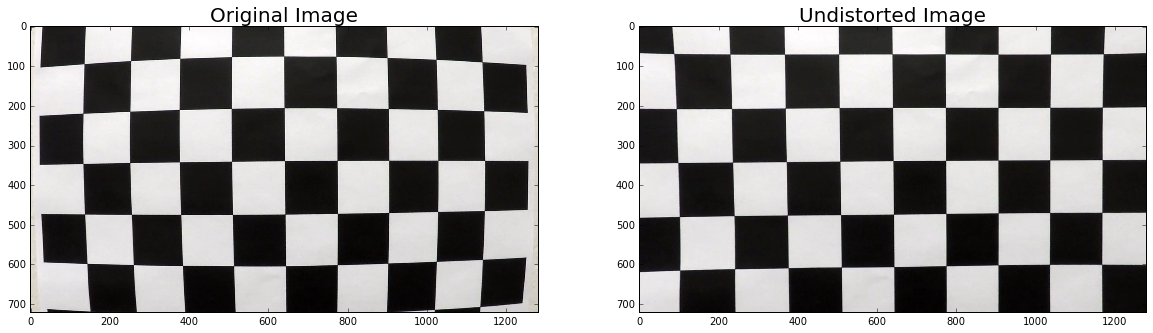

In [60]:
calibrated_img = cv2.imread('calibrated_dir/calibration1.jpg')
calibrated_img = cv2.cvtColor(calibrated_img, cv2.COLOR_BGR2RGB)

distorted_img = cv2.imread('camera_cal/calibration1.jpg')
distorted_img = cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB)

fig, (plt_original, plt_distorted) = plt.subplots(1, 2, figsize=(20,10))
plt_original.imshow(distorted_img)
plt_original.set_title('Original Image', fontsize=20)
plt_distorted.imshow(calibrated_img)
plt_distorted.set_title('Undistorted Image', fontsize=20)

100%|██████████| 8/8 [00:01<00:00,  6.55it/s]


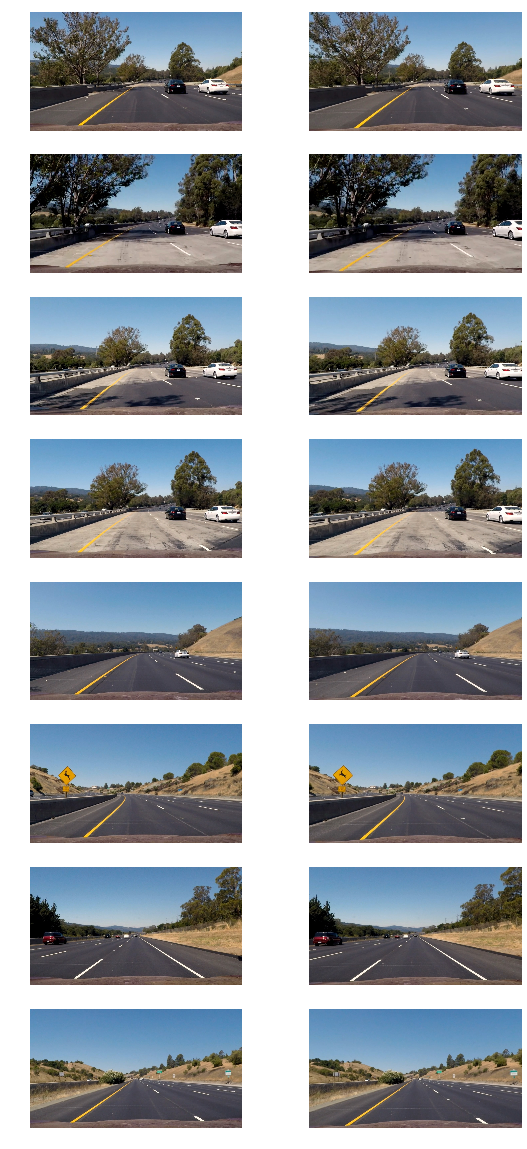

In [61]:
images = glob.glob('./test_images/*.jpg')

def undistort_test_image(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in tqdm(images):
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_undistorted = undistort_test_image(img, mtx, dist)
    
    axs[i].imshow(img_undistorted)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_undistorted, cmap='gray')
    axs[i].axis('off')
    i += 1

In [102]:
calibrated_img = cv2.imread('test_images/test1.jpg', cv2.IMREAD_UNCHANGED)
calibrated_img = cv2.cvtColor(calibrated_img, cv2.COLOR_BGR2RGB)

h,w = calibrated_img.shape[:2]

# src = np.float32([(550,475),
#                    (720,475),
#                    (235,685),
#                    (1084,685)
#                   ])

src = np.float32([(575,464),
              (707,464), 
              (258,682), 
              (1049,682)])

    
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

# These caus the picture to be really up side down
# src = np.float32([[545, 460],
#                     [735, 460],
#                     [1280, 700],
#                     [0, 700]])

# dst = np.float32([[0, 0],
#                  [1280, 0],
#                  [1280, 720],
#                  [0, 720]])

def corners_unwarp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return M, warped, Minv

M, distorted_img, Minv = corners_unwarp(calibrated_img, src, dst)


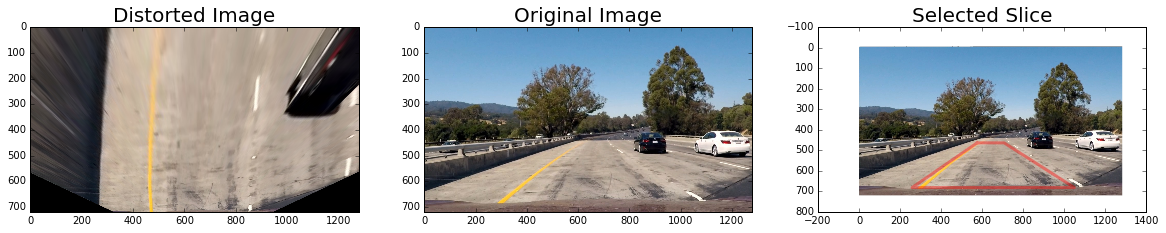

In [103]:

fig, (plt_original, plt_distorted, drawn_image) = plt.subplots(1, 3, figsize=(20,10))

drawn_image.imshow(calibrated_img)


plt_original.imshow(distorted_img)
plt_original.set_title('Distorted Image', fontsize=20)
plt_distorted.imshow(calibrated_img)
plt_distorted.set_title('Original Image', fontsize=20)

x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
drawn_image.set_title('Selected Slice', fontsize=20)
drawn_image.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

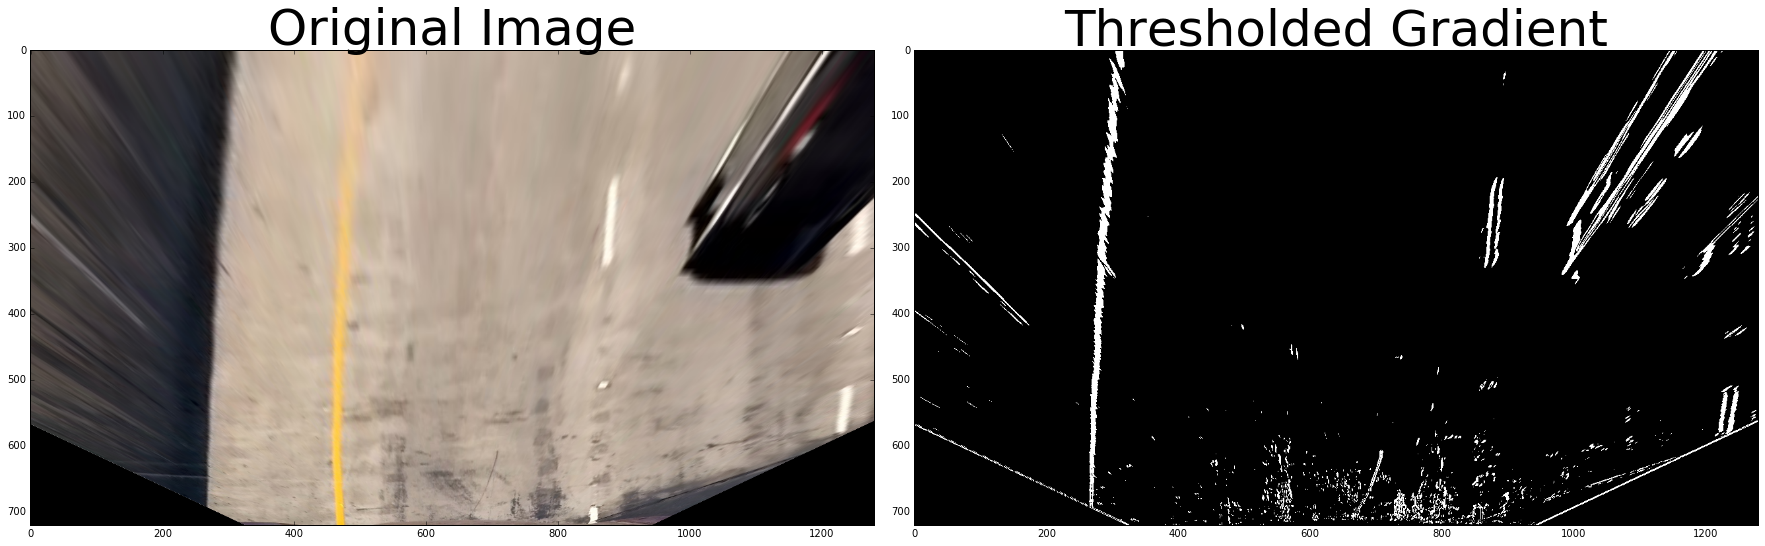

In [104]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=(3,3), thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        sobelx = None
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # plt.imshow(sxbinary, cmap='gray')
    
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) # Remove this line
    return binary_output



grad_binary = abs_sobel_thresh(distorted_img, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

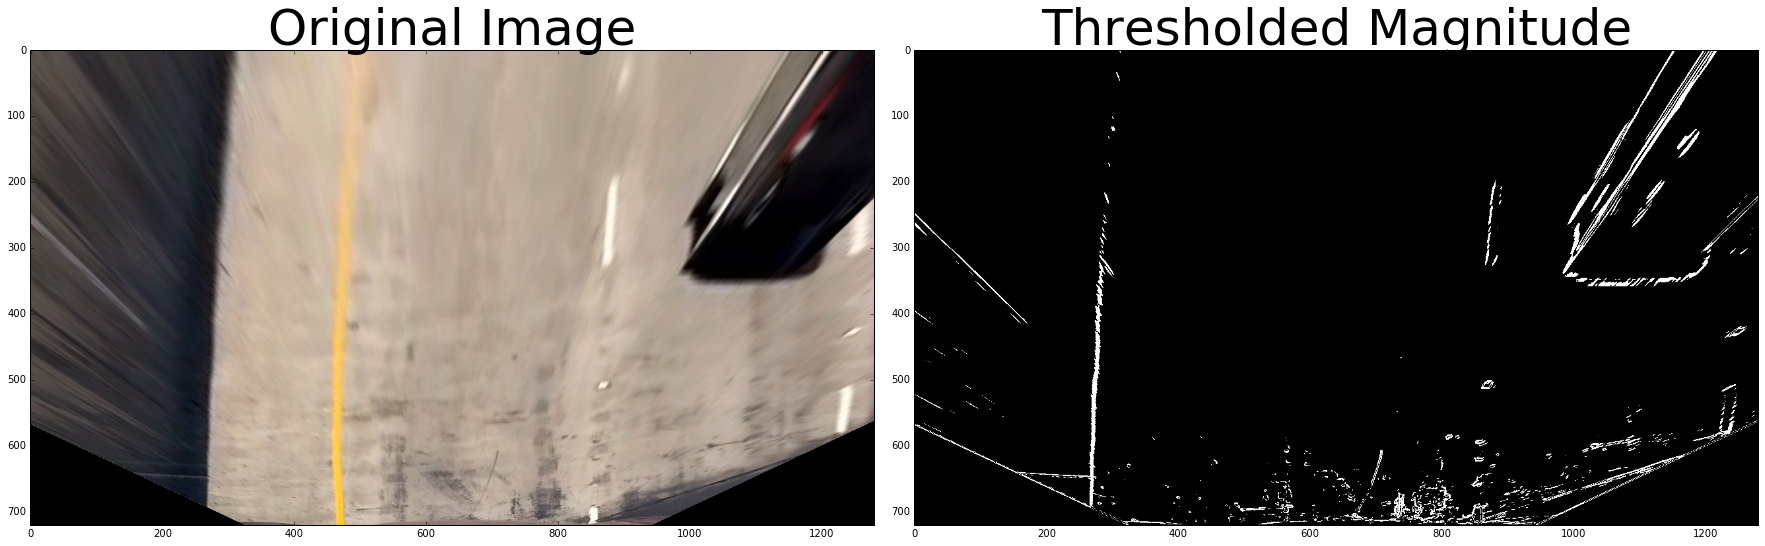

In [105]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    abs_sobelx = np.absolute(sobelxy)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # 5) Create a binary mask where mag thresholds are met
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) # Remove this line
    return binary_output

# Run the function
mag_binary = mag_thresh(distorted_img, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


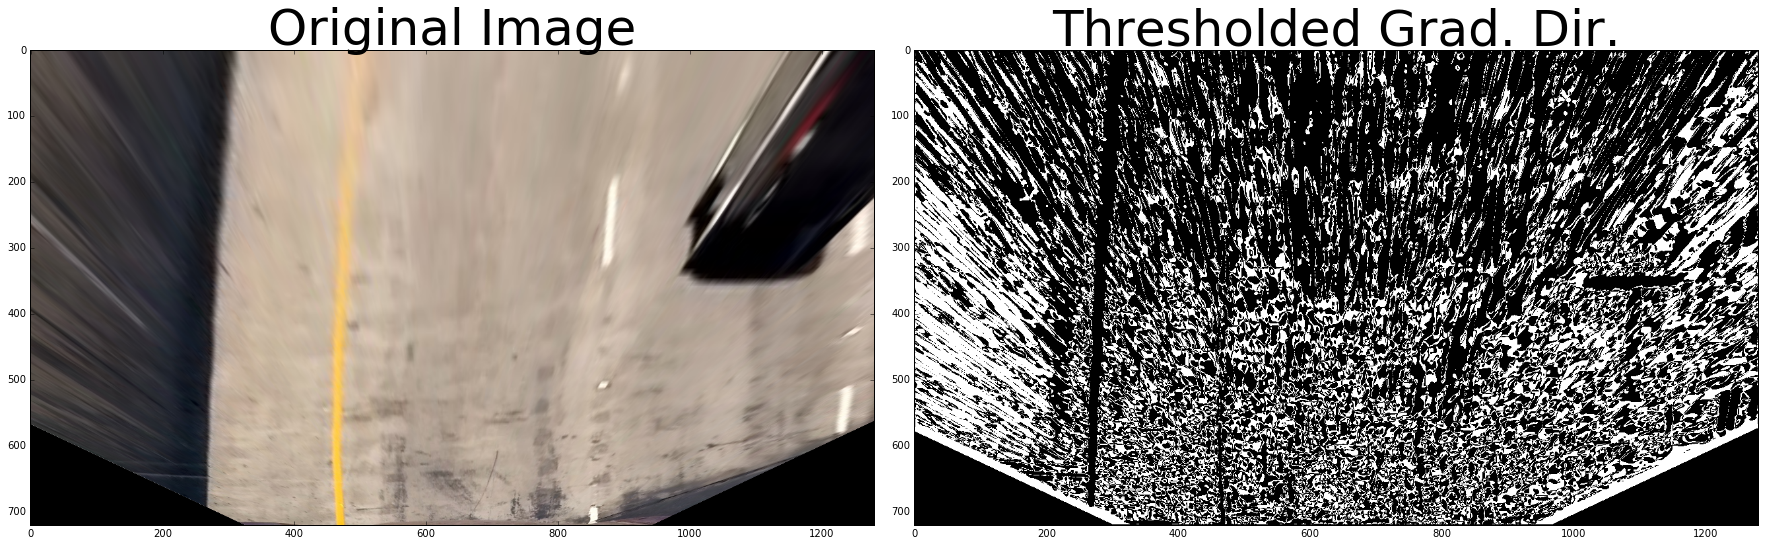

In [106]:


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

# Run the function
dir_binary = dir_threshold(distorted_img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

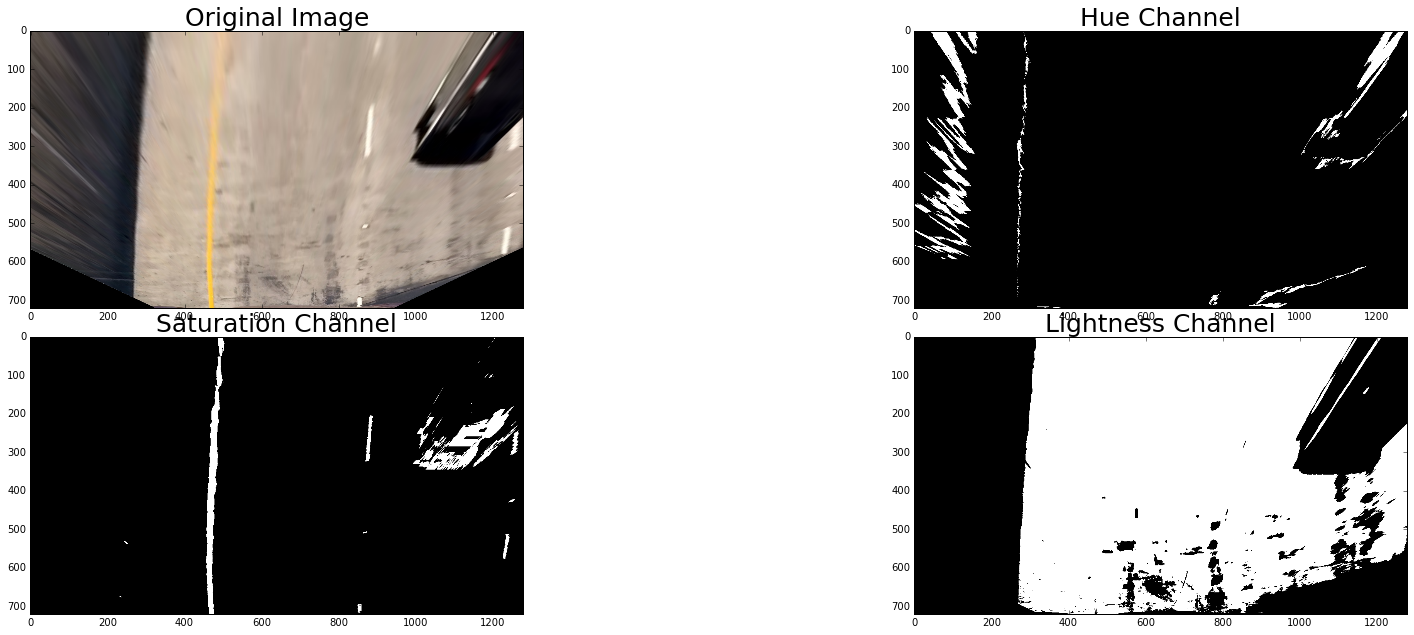

In [107]:
def hls_channel(image, thresh=(150,255), channel='S'):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    if channel == 'S':
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    elif channel == 'H':
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    elif channel == 'L':
        binary[(L > thresh[0]) & (L <= thresh[1])] = 1
        
    return binary

hchannel_img = hls_channel(distorted_img, channel='H')
schannel_img = hls_channel(distorted_img, channel='S')
lchannel_img = hls_channel(distorted_img, channel='L')

# Plot the result
f, ax = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(distorted_img)
ax[0].set_title('Original Image', fontsize=25)

ax[1].imshow(hchannel_img, cmap='gray')
ax[1].set_title('Hue Channel', fontsize=25)

ax[2].imshow(schannel_img, cmap='gray')
ax[2].set_title('Saturation Channel', fontsize=25)

ax[3].imshow(lchannel_img, cmap='gray')
ax[3].set_title('Lightness Channel', fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

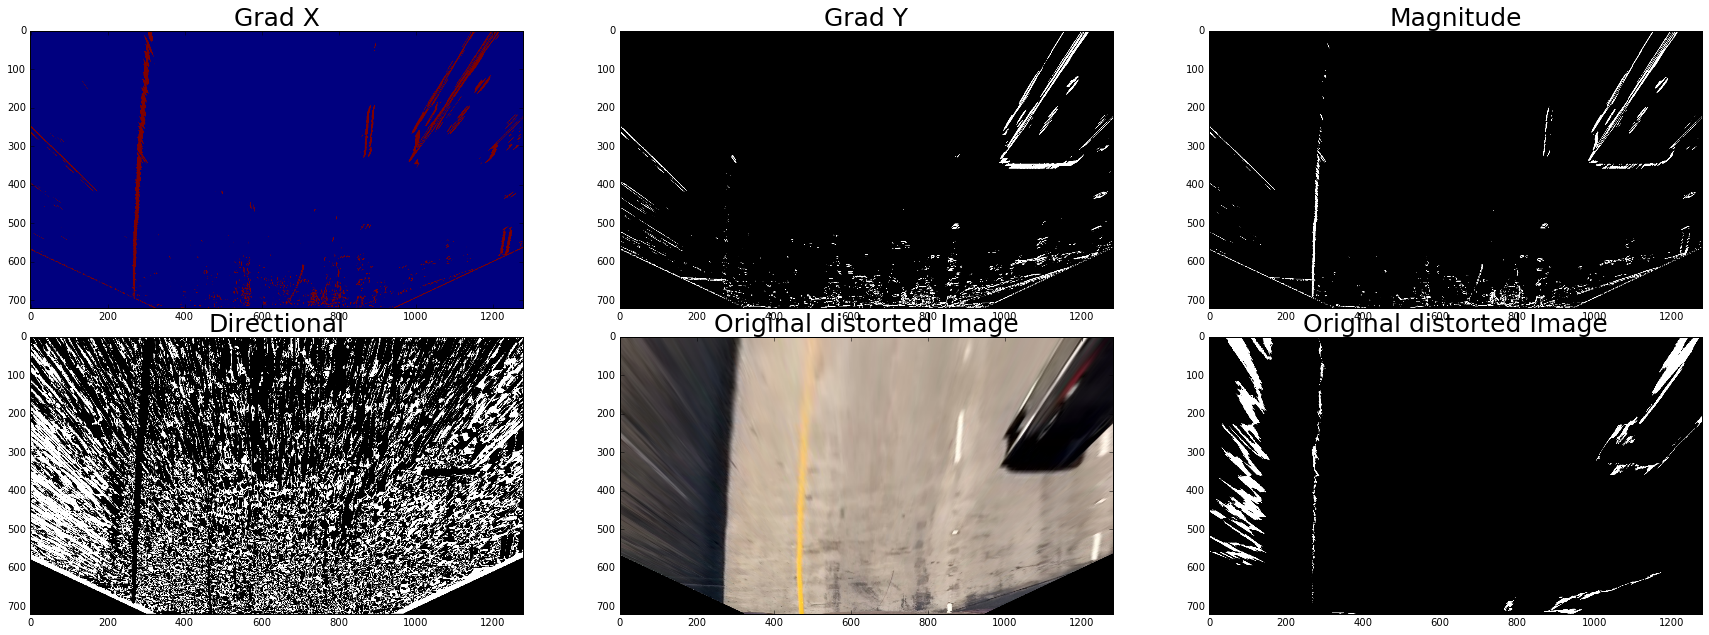

In [108]:

ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(distorted_img, orient='x',thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(distorted_img, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(distorted_img, sobel_kernel=3, mag_thresh=(30, 100))
# dir_binary = dir_threshold(distorted_img, sobel_kernel=ksize, thresh=(0, np.pi/2))
dir_binary = dir_threshold(distorted_img, sobel_kernel=15, thresh=(0.7, 1.3))



f, ax = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(gradx)
ax[0].set_title('Grad X', fontsize=25)

ax[1].imshow(grady, cmap='gray')
ax[1].set_title('Grad Y', fontsize=25)

ax[2].imshow(mag_binary, cmap='gray')
ax[2].set_title('Magnitude', fontsize=25)

ax[3].imshow(dir_binary, cmap='gray')
ax[3].set_title('Directional', fontsize=25)

ax[4].imshow(distorted_img, cmap='gray')
ax[4].set_title("Original distorted Image", fontsize=25)

ax[5].imshow(hchannel_img, cmap='gray')
ax[5].set_title("Original distorted Image", fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

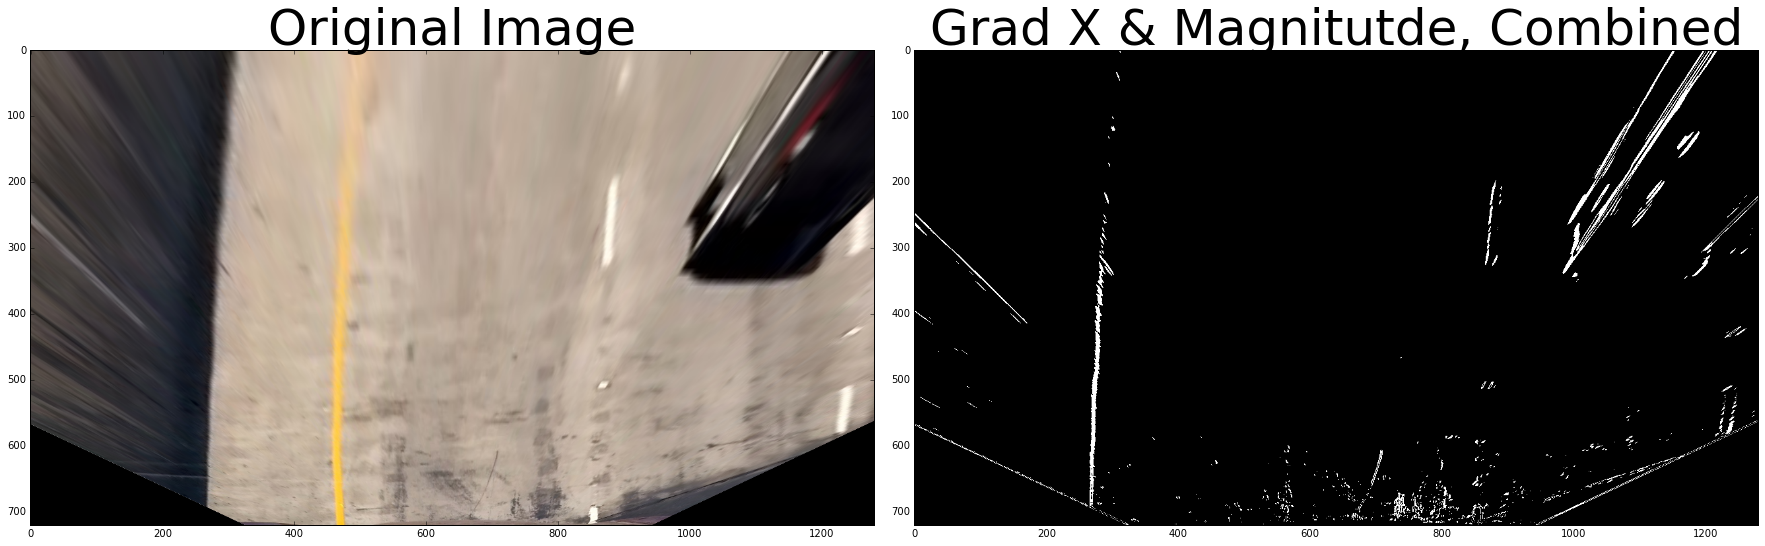

In [109]:
combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((gradx == 1) & (mag_binary == 1)) ] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Grad X & Magnitutde, Combined', fontsize=50) # Pop, Pop!
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

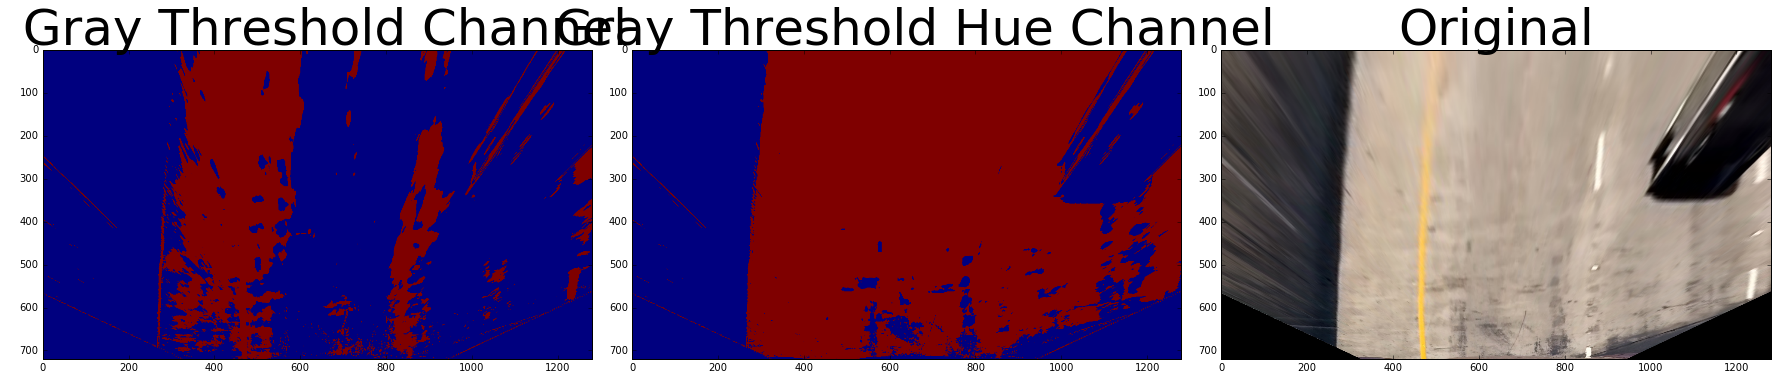

In [110]:
thresh = (180, 255)


gray = cv2.cvtColor(distorted_img, cv2.COLOR_RGB2GRAY)
binary_gray = np.zeros_like(gray)
binary_gray[(gray > thresh[0]) & (gray <= thresh[1])] = 1

combined_gray = np.zeros_like(binary_gray)
combined_gray[((binary_gray == 1) | (combined == 1)) ] = 1

hchannel_combined_img = np.zeros_like(combined_gray)
hchannel_combined_img[((combined_gray == 1) | (lchannel_img == 1))] = 1


f, (ax1, ax2, ax3 ) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_gray)
ax1.set_title(' Gray Threshold Channel', fontsize=50)

ax2.imshow(hchannel_combined_img)
ax2.set_title(' Gray Threshold Hue Channel', fontsize=50)

ax3.imshow(distorted_img)
ax3.set_title('Original', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


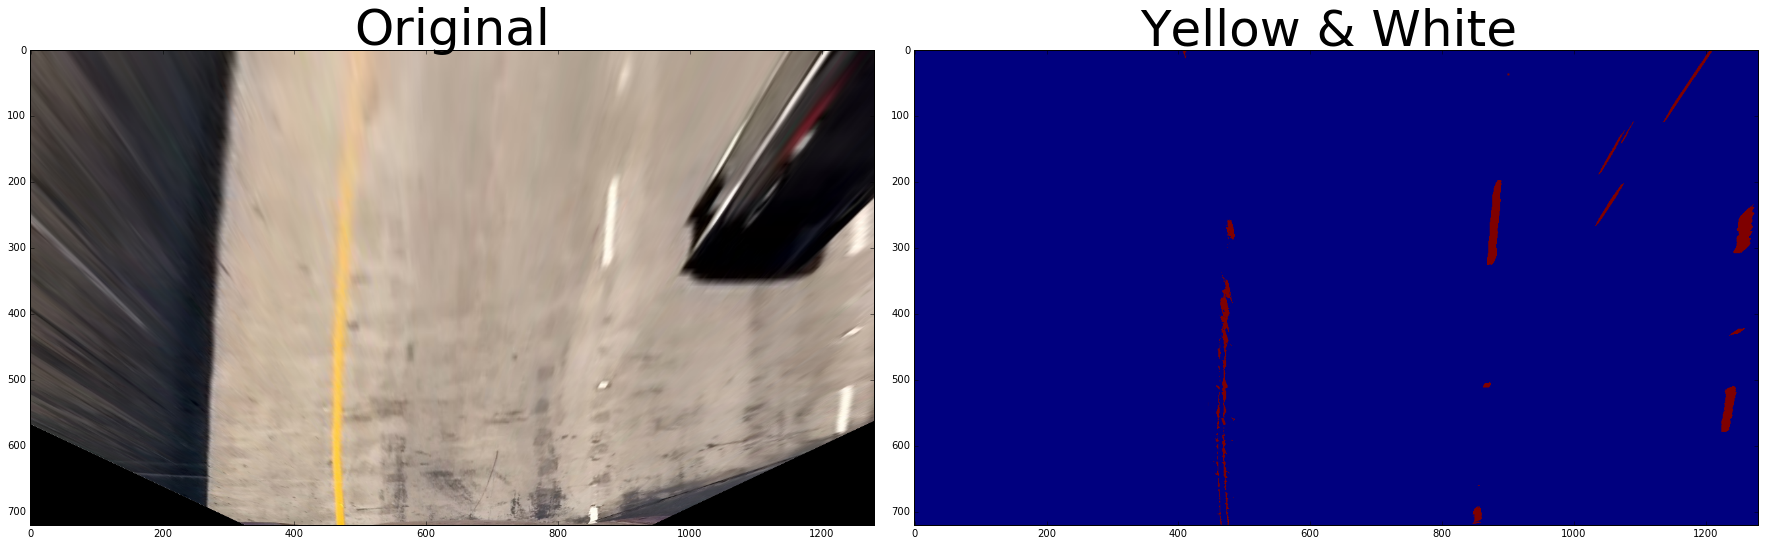

In [111]:
# recommended to me by the previous reviewer

def select_yellow(image):
    imag = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60]) #248	186	95	
    upper = np.array([50,190, 250])
    mask = cv2.inRange(hsv, lower, upper)
    #EFBF74

    return mask

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)

    return mask

def comb_thresh(image):
    yellow = select_yellow(image)
    white = select_white(image)

    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1

    return combined_binary

yellow_white_img = comb_thresh(distorted_img)
f, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_img)
ax1.set_title('Original', fontsize=50)

ax2.imshow(yellow_white_img)
ax2.set_title('Yellow & White ', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Combining Gradient-X, Magnitude Binary and Threshold Gradient's product and the binary grey channel gives us a very easy to find lane lines. It shows up quite well in the histogram. 

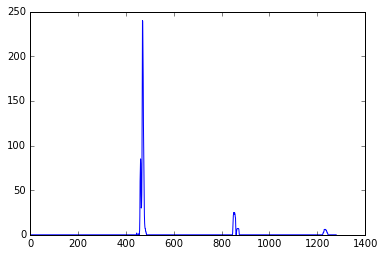

In [130]:
def find_histogram(img, plot_graph=False):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    for i, col in enumerate(histogram):
        if i < 250 or i > 1150:
            col = col / 10
        histogram[i] = col

    if plot_graph:
        plt.plot(histogram)
        
    return histogram
    
# lane_line_histogram = find_histogram(combined_gray, plot_graph=True)
lane_line_histogram = find_histogram(yellow_white_img, plot_graph=True)




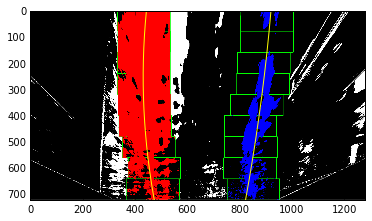

In [124]:
def sliding_windows(binary_warped, histogram, plot_output=False):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plot_output is True:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return binary_warped, left_fit, right_fit
    
def find_next_path(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return result, left_fit, right_fit
    
binary_warped, left_fit, right_fit = sliding_windows(combined_gray,lane_line_histogram, plot_output=True)

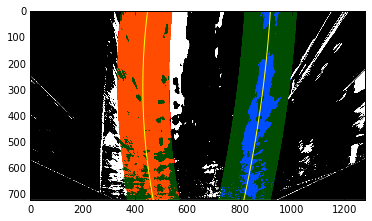

In [115]:
r, left_fit, right_fit = find_next_path(binary_warped, left_fit, right_fit)

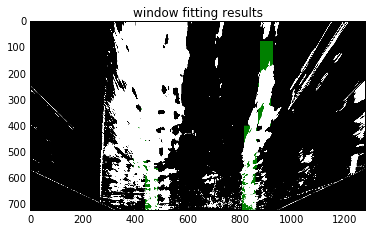

In [116]:
warped = combined_gray
# window settings
window_width = 50 
window_height = 160 # Break image into 9 vertical layers since image height is 720
margin = 75 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [117]:
def find_curvature(image, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad, left_fit_cr, right_fit_cr
    # Example values: 632.1 m    626.2 m

left_curverad, right_curverad, left_fit_cr, right_fit_cr = find_curvature(binary_warped, left_fit, right_fit)
print(left_curverad, 'm', right_curverad, 'm')

491.9733193361149 m 528.0958831864995 m


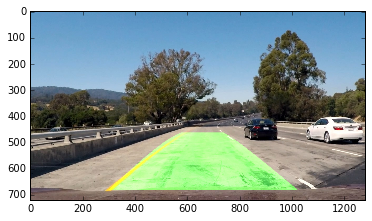

In [118]:
def draw_lane_lines(l_fit, r_fit, Minv, original_img, binary_img):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

result = draw_lane_lines(left_fit, right_fit, Minv, calibrated_img, binary_warped)
plt.imshow(result)

In [119]:
# recommended to me by the previous reviewer

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)

    return mask

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)

    return mask

def comb_thresh(image):
    yellow = select_yellow(image)
    white = select_white(image)

    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1

    return combined_binary


In [120]:
def pipeline(image):
    """Take an image and find the lane lines

    """
    h,w = image.shape[:2]

    src = np.float32([(550,475),
                       (720,475),
                       (235,685),
                       (1084,685)
                      ])

    src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    
    dst = np.float32([(450,0),
                      (w-450,0),
                      (450,h),
                      (w-450,h)])
    
    M, distorted_img, Minv = corners_unwarp(image, src, dst)
    
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(distorted_img, orient='x',thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(distorted_img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(distorted_img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(distorted_img, sobel_kernel=15, thresh=(0.7, 1.3))

    combined = np.zeros_like(mag_binary)
    
    lchannel_img = hls_channel(distorted_img, channel='L')
    
    white_and_yellow_channel = comb_thresh(distorted_img)

# #     combined[((gradx == 1) & (mag_binary == 1)) ] = 1
#     combined[((white_and_yellow_channel == 1) & (lchannel_img == 1)) ] = 1

#     thresh = (180, 255)

#     gray = cv2.cvtColor(distorted_img, cv2.COLOR_RGB2GRAY)
#     binary_gray = np.zeros_like(gray)
#     binary_gray[(gray > thresh[0]) & (gray <= thresh[1])] = 1

#     combined_gray = np.zeros_like(binary_gray)
#     combined_gray[((binary_gray == 1) | (combined == 1)) ] = 1

    combined_gray = white_and_yellow_channel

    lane_line_histogram = find_histogram(combined_gray, plot_graph=False)

    binary_warped, left_fit, right_fit = sliding_windows(combined_gray,lane_line_histogram)
    
#     r, left_fit, right_fit = find_next_path(binary_warped, left_fit, right_fit)
    
    left_curverad, right_curverad, left_fit_cr, right_fit_cr = find_curvature(binary_warped, left_fit, right_fit)

    result = draw_lane_lines(left_fit, right_fit, Minv, image, binary_warped)

    return result

100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


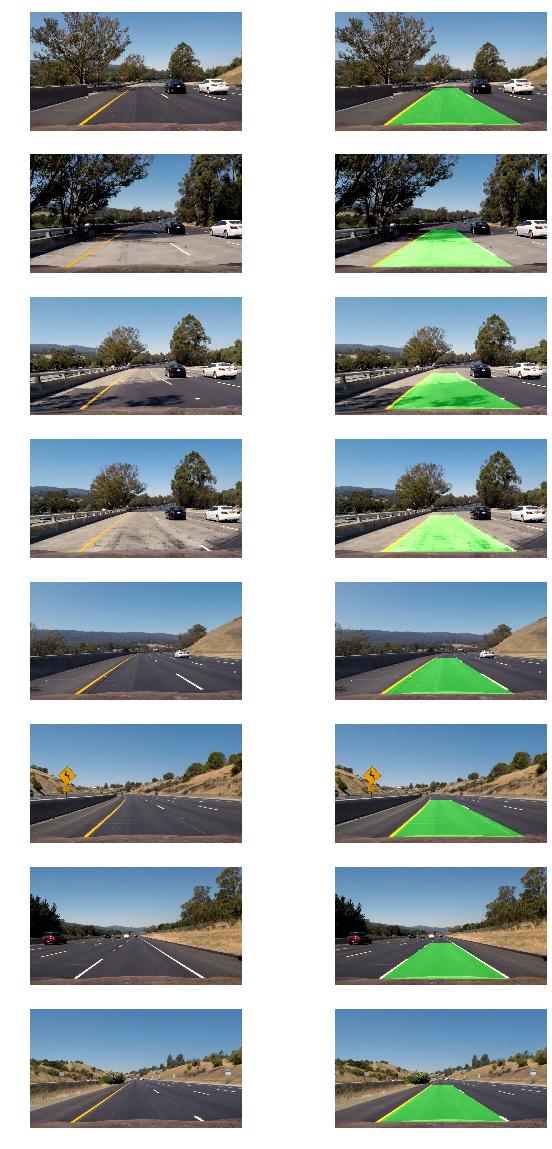

In [125]:
images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
# fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in tqdm(images):
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_painted = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_painted)
    axs[i].axis('off')
    i += 1



In [131]:

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [00:37<04:35,  4.03it/s]


 24%|██▍       | 303/1261 [01:15<03:57,  4.03it/s]


 36%|███▌      | 454/1261 [01:53<03:21,  4.01it/s]


 48%|████▊     | 605/1261 [02:31<02:44,  3.99it/s]


 60%|█████▉    | 756/1261 [03:10<02:07,  3.97it/s]


 72%|███████▏  | 907/1261 [03:49<01:29,  3.95it/s]


 84%|████████▍ | 1057/1261 [04:28<00:51,  3.94it/s]


 96%|█████████▌| 1205/1261 [05:05<00:14,  3.94it/s]


100%|█████████▉| 1260/1261 [05:19<00:00,  3.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 59s, sys: 1min 11s, total: 7min 11s
Wall time: 5min 20s


In [ ]:
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 15%|█▍        | 72/485 [00:18<01:45,  3.92it/s]

In [128]:
video_output1 = 'harder_challenge_video_output.mp4'
video_input1 = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



 13%|█▎        | 152/1200 [00:43<04:57,  3.52it/s]


 25%|██▌       | 303/1200 [01:24<04:11,  3.57it/s]


 38%|███▊      | 454/1200 [02:10<03:34,  3.48it/s]


 50%|█████     | 605/1200 [02:52<02:49,  3.51it/s]


 63%|██████▎   | 756/1200 [03:39<02:08,  3.44it/s]


 76%|███████▌  | 907/1200 [04:25<01:25,  3.41it/s]


 77%|███████▋  | 921/1200 [04:29<01:21,  3.42it/s]


TypeError: expected non-empty vector for x